In [2]:
import baccoemu
import chainconsumer
import emcee
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import scipy
import warnings

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plot_utils
import plotter
import utils
import run_inference as rinf
import moment_network as mn

%load_ext autoreload
%autoreload 2

2024-04-09 12:19:24.078412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Importing pyfftw first


In [3]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Results

In [7]:
plot_dir = '../plots/plots_2024-04-05'
save_plots = False


In [8]:
data_mode = 'emuPk'
tag_emuPk = '_2param'
box_size = 500.
tag_errG = f'_boxsize{int(box_size)}'
n_rlzs_per_cosmo = 5
tag_datagen = f'{tag_emuPk}{tag_errG}_nrlzs{n_rlzs_per_cosmo}'
tag_data = '_'+data_mode + tag_datagen
dir_data = '../data/emuPks'

In [12]:
if data_mode == 'emuPk':
    # leave this fixed so we don't mix the sets; then we'll subsample
    frac_train=0.85
    frac_val=0.05
    frac_test=0.1
elif data_mode == 'muchisimocks':
    frac_train=0.70
    frac_val=0.15
    frac_test=0.15
    
n_train = 8500
n_val = 250
n_test = 1000

In [13]:
# fn_emuPk = f'../data/emuPks/emuPks{tag_emuPk}.npy'
# fn_emuPkerrG = f'../data/emuPks/emuPks_errgaussian{tag_emuPk}{tag_errG}.npy'
# fn_emuPk_noisy = f'../data/emuPks/emuPks_noisy{tag_datagen}.npy'
# fn_emuPk_params = f'../data/emuPks/emuPks_params{tag_emuPk}.txt'
# fn_emuk = f'../data/emuPks/emuPks_k{tag_emuPk}.txt'
# fn_bias_vector = f'../data/emuPks/bias_params.txt'
# fn_rands = f'{dir_data}/randints{tag_emuPk}.npy'
    
# n_rlzs_per_cosmo = 5
# theta, y, y_err, k, param_names = rinf.load_data_emuPk(dir_data, tag_datagen, tag_errG, n_rlzs_per_cosmo=n_rlzs_per_cosmo)

In [14]:
# Pk = np.load(fn_emuPk_noisy, allow_pickle=True)   
# Pk_noiseless = np.load(fn_emuPk, allow_pickle=True)
# n_emuPk = Pk_noiseless.shape[0]
# k = np.genfromtxt(fn_emuk)
# bias_vector = np.loadtxt(fn_bias_vector)

# theta_noiseless = np.genfromtxt(fn_emuPk_params, delimiter=',', names=True)
# gaussian_error_pk_noiseless = np.load(fn_emuPkerrG, allow_pickle=True)
# theta = utils.repeat_arr_rlzs(theta_noiseless, n_rlzs=n_rlzs_per_cosmo)
# gaussian_error_pk = utils.repeat_arr_rlzs(gaussian_error_pk_noiseless, n_rlzs=n_rlzs_per_cosmo)

In [15]:
arrs = rinf.load_data_emuPk(dir_data, 
                    tag_emuPk, tag_errG, tag_datagen,
                    n_rlzs_per_cosmo=n_rlzs_per_cosmo,
                    return_noiseless=True)
theta, Pk, gaussian_error_pk, k, param_names, bias_vector, random_ints, \
               theta_noiseless, Pk_noiseless, gaussian_error_pk_noiseless = arrs
n_emuPk = len(random_ints)

In [16]:
y = Pk
y_err = gaussian_error_pk

In [17]:
idxs_train, idxs_val, idxs_test = utils.idxs_train_val_test(random_ints, 
                                frac_train=frac_train, frac_val=frac_val, frac_test=frac_test)

idxs_train = idxs_train[:n_train]
idxs_val = idxs_val[:n_val]
idxs_test = idxs_test[:n_test]

idxs_train_orig = idxs_train.copy()
idxs_train = []
for n_rlz in range(n_rlzs_per_cosmo):
    #idxs_train_nrlzs.extend(idxs_train*(nc+1))
    idxs_train.extend(idxs_train_orig + n_rlz*n_emuPk)
idxs_train = np.array(idxs_train)
print(idxs_train.shape)
            
theta_train, theta_val, theta_test = utils.split_train_val_test(theta, idxs_train, idxs_val, idxs_test)
y_train, y_val, y_test = utils.split_train_val_test(y, idxs_train, idxs_val, idxs_test)
y_err_train, y_err_val, y_err_test = utils.split_train_val_test(y_err, idxs_train, idxs_val, idxs_test)

Pk_noiseless_train, Pk_noiseless_val, Pk_noiseless_test = utils.split_train_val_test(Pk_noiseless, idxs_train_orig, idxs_val, idxs_test)

0.85 0.05 0.1
(42500,)


In [18]:
Pk_train, Pk_val, Pk_test = y_train, y_val, y_test
gaussian_error_pk_train, gaussian_error_pk_val, gaussian_error_pk_test = y_err_train, y_err_val, y_err_test

In [19]:
print(theta_train.shape, theta_val.shape, theta_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
print(y_err_train.shape, y_err_val.shape, y_err_test.shape)

(42500, 2) (250, 2) (1000, 2)
(42500, 24) (250, 24) (1000, 24)
(42500, 24) (250, 24) (1000, 24)


In [13]:
print(Pk_train[0][:3])
print(Pk_train[n_train][:3])

print(theta_train[0][:3])
print(theta_train[n_train][:3])

[61129.66623096 51710.80402846 48776.7256603 ]
[59764.3983891  47970.98796428 42468.36749499]
[0.32010384 0.67616403]
[0.32010384 0.67616403]


In [14]:
# overall quantities
deltas_pk_per_err = []
deltas_pk_per_err_scaled = []
for ii in range(Pk_train.shape[0]):

    #  ii = i+n_rlz*n_train, so i = ii - n_rlz*n_train
    n_rlz = ii//n_train
    i = ii - n_rlz*n_train
    # in this case the orig emu pks are what we want
    pk_model_unscaled = Pk_noiseless_train[i]
    delta_pk_per_err = (pk_model_unscaled-Pk_train[ii])/gaussian_error_pk_train[ii]
    deltas_pk_per_err.append(delta_pk_per_err)
    
deltas_pk_per_err = np.array(deltas_pk_per_err)
delta_pk_per_err_16 = np.percentile(deltas_pk_per_err, 16, axis=0)
delta_pk_per_err_84 = np.percentile(deltas_pk_per_err, 84, axis=0)
delta_pk_per_err_std = np.std(deltas_pk_per_err, axis=0)

Text(0, 0.5, '$(P_\\text{emu}-P_\\text{data})/\\sigma_\\text{G}$')

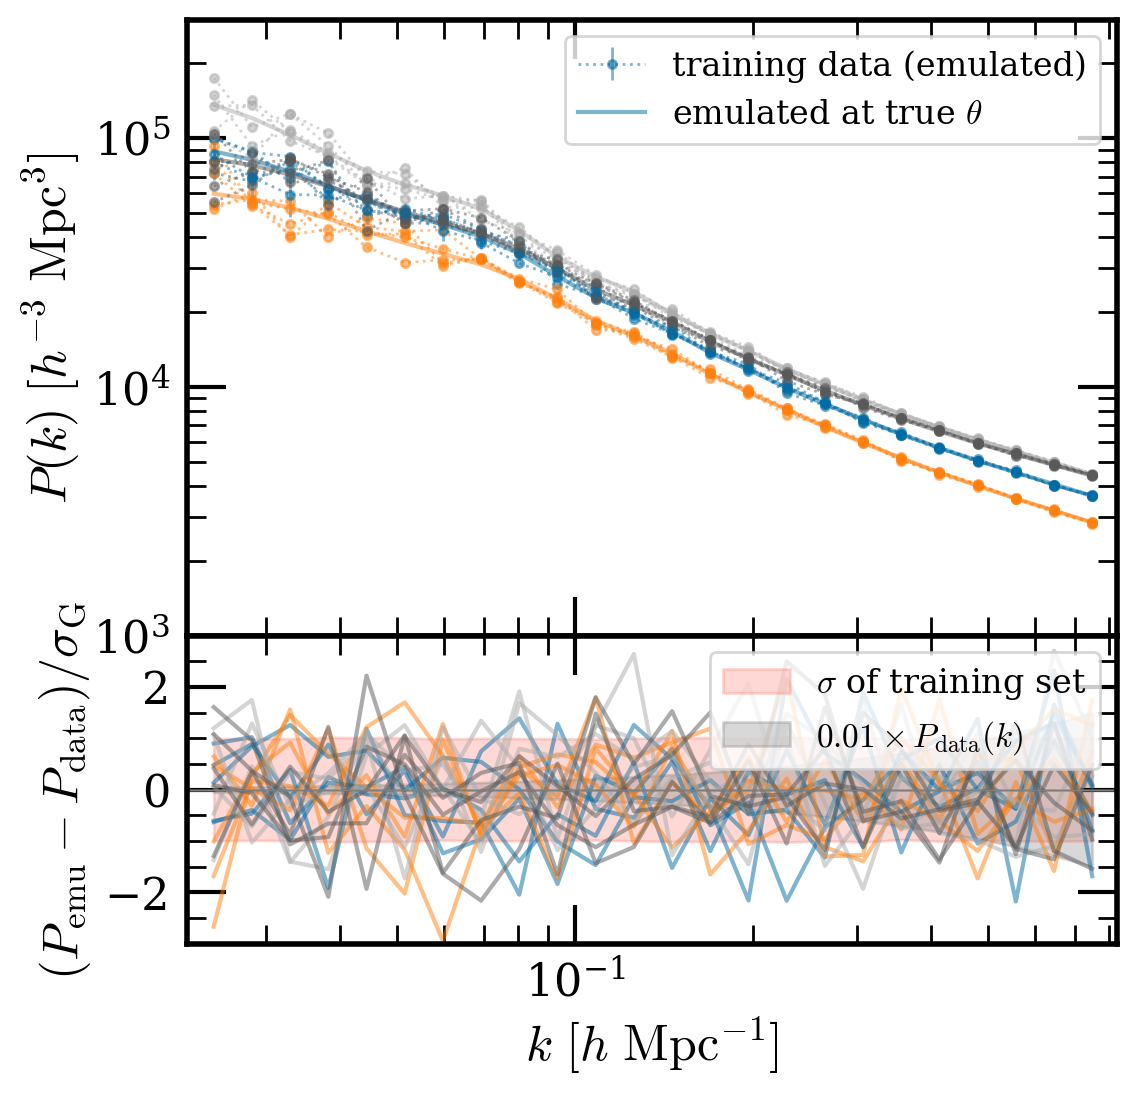

In [15]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)
    
# a few examples
#colors = ['red', 'orange', 'green', 'blue', 'purple']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lw = 1.5
show_error_all = False
first = True

rng = np.random.default_rng(42)
n_plot = 4
idxs_plot_train = rng.choice(np.arange(n_train), n_plot, replace=False)

for i, idx_plot_train in enumerate(idxs_plot_train):
    # for pp in range(len(param_names)):
    #     cosmo_params[emu_param_names[pp]] = theta[i][pp]
    # _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
    #                                                     **cosmo_params)
    # in this case the orig emu pks are what we want
    pk_model_unscaled = Pk_noiseless_train[idx_plot_train]
    
    if first:
        label_true = 'training data (emulated)'
        label_emu = r'emulated at true $\theta$'
        label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
    else:
        label_true, label_emu, label_stdev = None, None, None

    for n_rlz in range(n_rlzs_per_cosmo):
        ii = idx_plot_train+n_rlz*n_train
        
        if first or show_error_all:
            # noisy emupk with errorbars
            axarr[0].errorbar(k, Pk_train[ii], yerr=gaussian_error_pk_train[ii], 
                            ls=':', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i], lw=1)
        else:
            # noisy emupk 
            axarr[0].plot(k, Pk_train[ii], ls=':', marker='o', markersize=3, alpha=0.5,
                          #label=label_true, 
                          color=colors[i], lw=1)
    
        axarr[1].plot(k, (pk_model_unscaled-Pk_train[ii])/gaussian_error_pk_train[ii], ls='-', alpha=0.5, color=colors[i], lw=lw)
        first = False

    # emuPk noiseless
    axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)
        
    axarr[1].axhline(0, color='grey', lw=0.5)
    
   

#axarr[1].fill_between(k, delta_pk_per_err_16, delta_pk_per_err_84, color='cyan', alpha=0.3,
#                      label='16-84 percentile of training set')
axarr[1].fill_between(k, -delta_pk_per_err_std, delta_pk_per_err_std, color='salmon', alpha=0.3,
                      label=r'$\sigma$ of training set')

# test data
# color_test = 'k'
# # for pp in range(len(param_names)):
# #     cosmo_params[emu_param_names[pp]] = theta_test[idx_test][pp]
# # _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
# #                                                  **cosmo_params)
# # in this case the orig emu pks are what we want
# pk_model_unscaled = Pk_noiseless_test[idx_test]
# axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, color=color_test, lw=3)
# axarr[0].errorbar(k, Pk_test[idx_test], yerr=gaussian_error_pk_test[idx_test], 
#                   ls='None', marker='o', markersize=6, alpha=0.5, label=f'test data', color=color_test)
# axarr[1].plot(k, (pk_model_unscaled-Pk_test[idx_test])/gaussian_error_pk_test[idx_test], ls='-', alpha=0.5, color=color_test)

 # 1p emu error
err_1p = 0.01*pk_model_unscaled
label_err1p = r'$0.01 \times P_\text{data}(k)$'
axarr[1].fill_between(k, -err_1p/gaussian_error_pk_train[idx_plot_train], 
                          err_1p/gaussian_error_pk_train[idx_plot_train], color='grey', alpha=0.3,
                            label=label_err1p)

# plot settings
plt.xscale('log')
axarr[0].set_yscale('log')
    
#plt.xlim(1e-2, 0.75)
plt.xlim(np.min(k)*0.9, np.max(k)*1.1)
axarr[0].set_ylim(1e3, 3e5)
axarr[1].set_ylim(-3, 3)
    
handles, labels = axarr[0].get_legend_handles_labels()
#order = [1,0,2]
order = [1,0]
axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
# axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=12)

axarr[1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=18)
axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=18)    
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=18)


In [16]:
param_labels = [utils.param_label_dict[param_name] for param_name in param_names]

In [17]:
# only need for bounds, TODO save bounds somwehere
emu, emu_bounds, emu_param_names = utils.load_emu()
dict_bounds = {name: emu_bounds[emu_param_names.index(name)] for name in param_names}

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2024-04-05 22:06:39.532511: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_thread

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using 

Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/mlenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Results for specific model

In [18]:
n_train = 1000
tag_inf = '_'+data_mode + tag_datagen

tag_inf += f'_ntrain{n_train}'
#tag_inf += f'_nrlzs{n_rlzs_per_cosmo}'
dir_mn = f'../data/results_moment_network/mn{tag_inf}'
print(dir_mn)

../data/results_moment_network/mn_emuPk_2param_boxsize500_nrlzs5_ntrain1000


In [19]:
theta_test_pred = np.load(f'{dir_mn}/theta_test_pred.npy')
covs_test_pred = np.load(f'{dir_mn}/covs_test_pred.npy')
print(theta_test_pred.shape, covs_test_pred.shape)

(1000, 2) (1000, 2, 2)


In [20]:
# moment_network = mn.MomentNetwork(tag_mn=tag_inf)
# moment_network.load_model_mean()
history_mean = np.load(f'{dir_mn}/model_mean_history.npy', allow_pickle=True).item()
history_cov = np.load(f'{dir_mn}/model_cov_history.npy', allow_pickle=True).item()

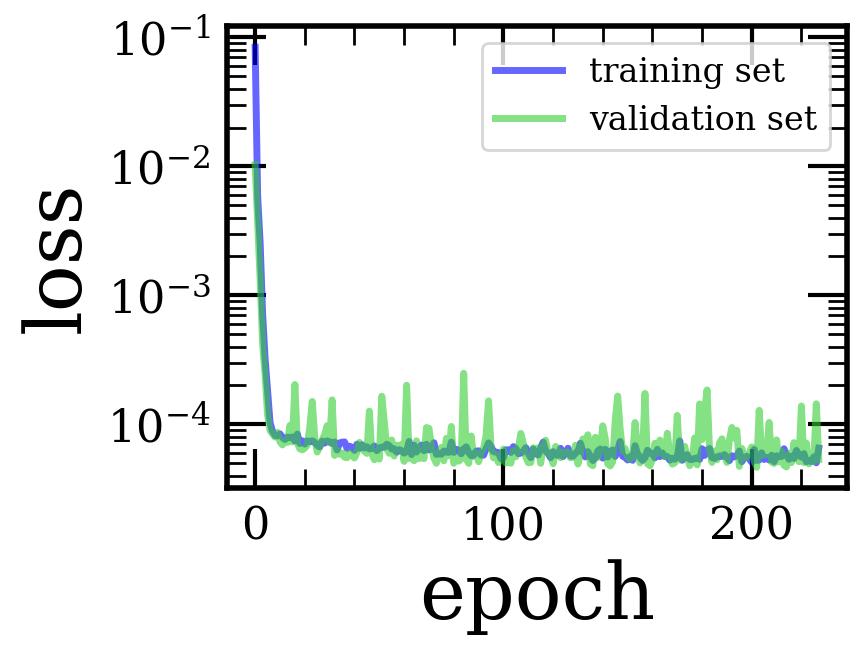

In [21]:
plotter.plot_loss(history_mean)

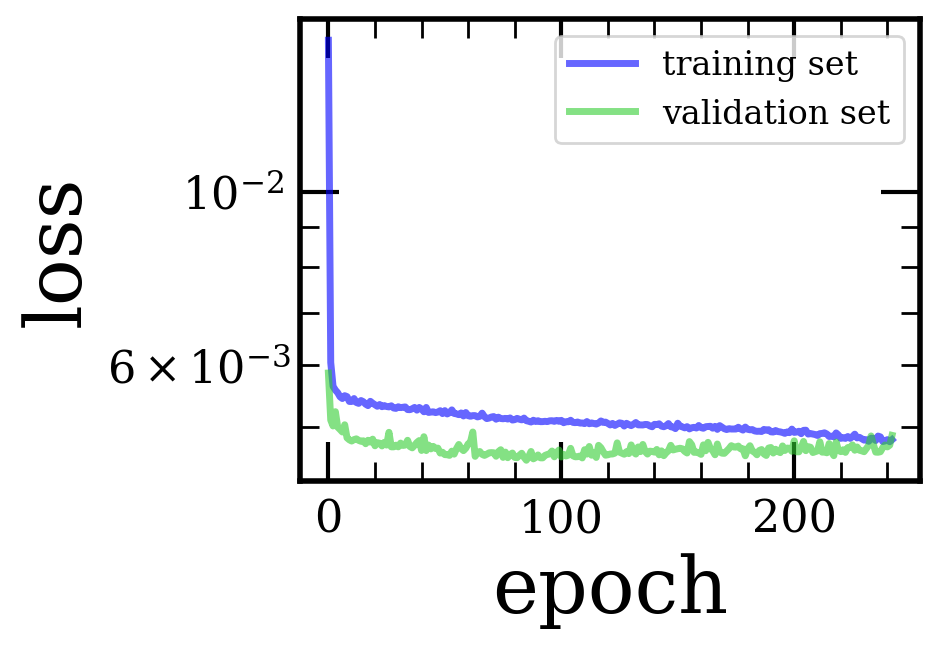

In [22]:
plotter.plot_loss(history_cov)

In [23]:
theta_test_pred

array([[0.2718531 , 0.78953314],
       [0.29773533, 0.78457713],
       [0.3311367 , 0.8579562 ],
       ...,
       [0.39157584, 0.8532797 ],
       [0.33277467, 0.72248423],
       [0.25638467, 0.8349447 ]], dtype=float32)

In [24]:
theta_test

array([[0.28384846, 0.79366932],
       [0.32321511, 0.78906614],
       [0.3359321 , 0.85786719],
       ...,
       [0.39688798, 0.85636775],
       [0.34272544, 0.72492165],
       [0.2670316 , 0.83629647]])

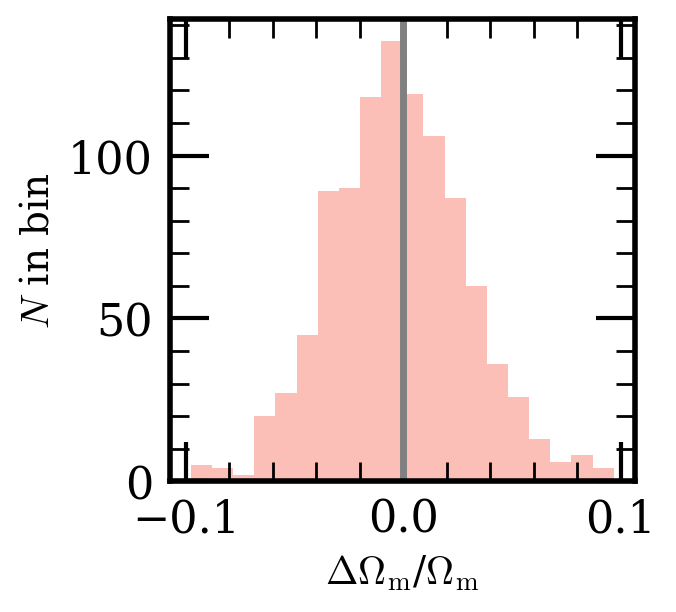

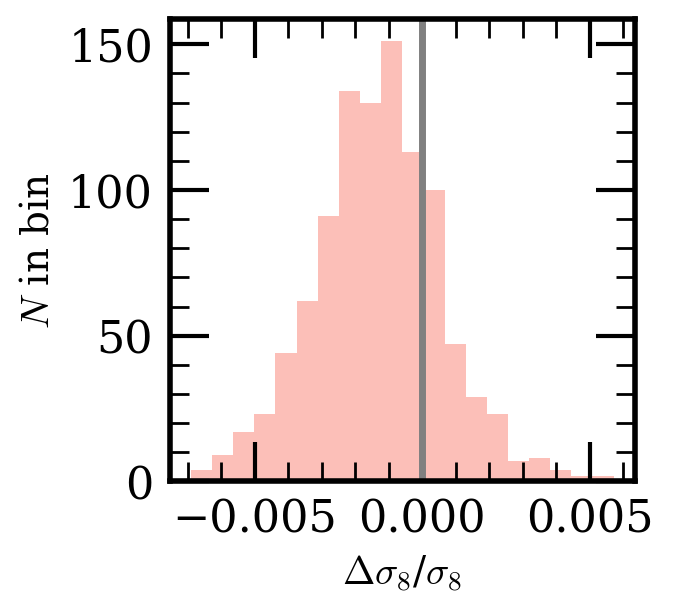

In [25]:

fracdiffs = (theta_test_pred - theta_test)/theta_test
plotter.plot_hists_mean(fracdiffs, param_labels)


In [38]:
tags_inf = ['_emuPk_2param_boxsize500_ntrain1000',
            '_emuPk_2param_boxsize500_ntrain5000',
            '_emuPk_2param_boxsize500_nrlzs5_ntrain1000',
            ]

labels_extra = ['(N_train=1000)',
                '(N_train=5000)', 
                '(N_train=1000 x 5 rlzs)']
#colors = [utils.color_dict_methods[meth] for meth in methods]
colors = ['#63E0CF', 'blue', 'magenta']
param_labels = [utils.param_label_dict[param_name] for param_name in param_names]

fracdiffs_arr = []
theta_test_arr = []
theta_test_pred_arr = []
covs_test_pred_arr = []
for tag_inf in tags_inf:
    _theta_test_pred, _covs_test_pred  = utils.get_moments_test_mn(tag_inf)
    fracdiffs_mn = (_theta_test_pred - theta_test)/theta_test
    fracdiffs_arr.append(fracdiffs_mn)
    theta_test_arr.append(theta_test)
    theta_test_pred_arr.append(_theta_test_pred)
    covs_test_pred_arr.append(_covs_test_pred)
fracdiffs_arr = np.array(fracdiffs_arr)
theta_test_arr = np.array(theta_test_arr)
theta_test_pred_arr = np.array(theta_test_pred_arr)
covs_test_pred_arr = np.array(covs_test_pred_arr)

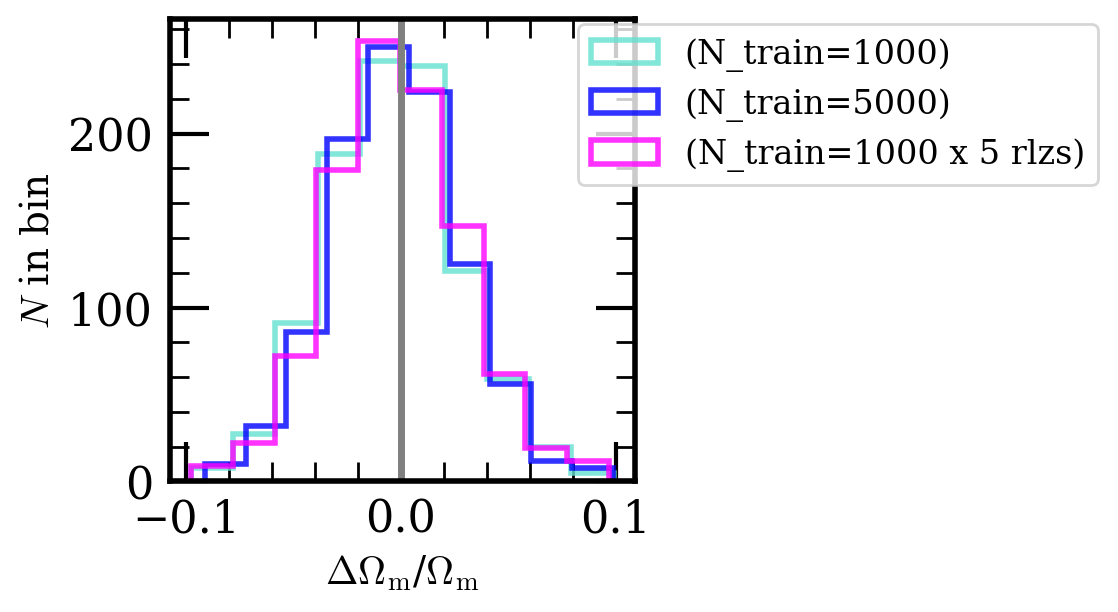

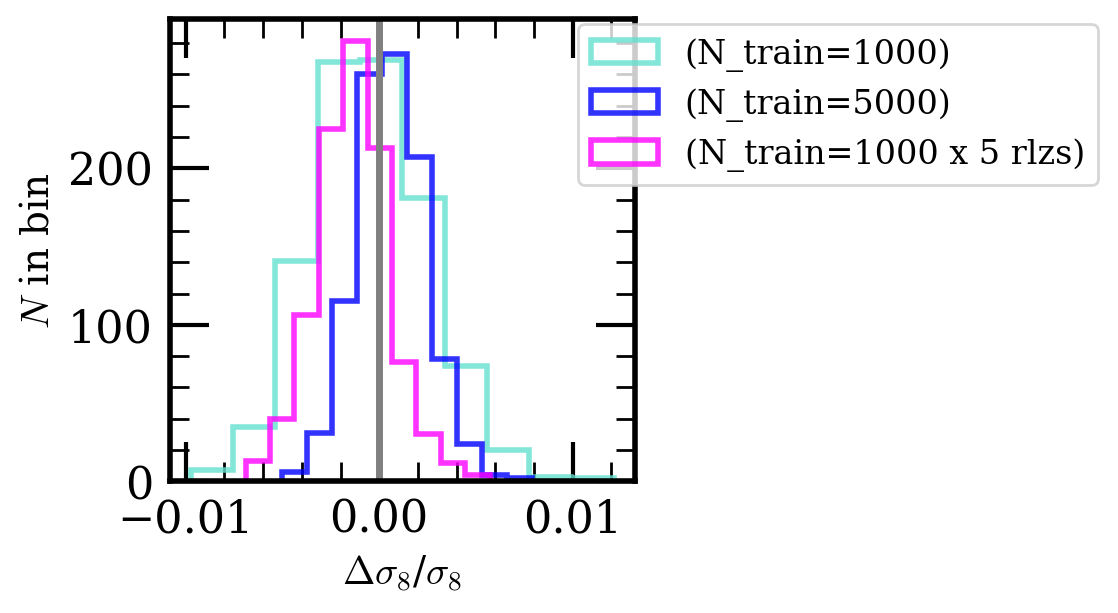

In [39]:
plotter.plot_hists_mean(fracdiffs_arr, param_labels, 
                        color_arr=colors, label_arr=labels_extra,
                        bins=10, alpha=0.8, histtype='step')

/dipc/kstoreyf/muchisimocks/scripts/plotter.py:93: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(np.diag(cov_pred))


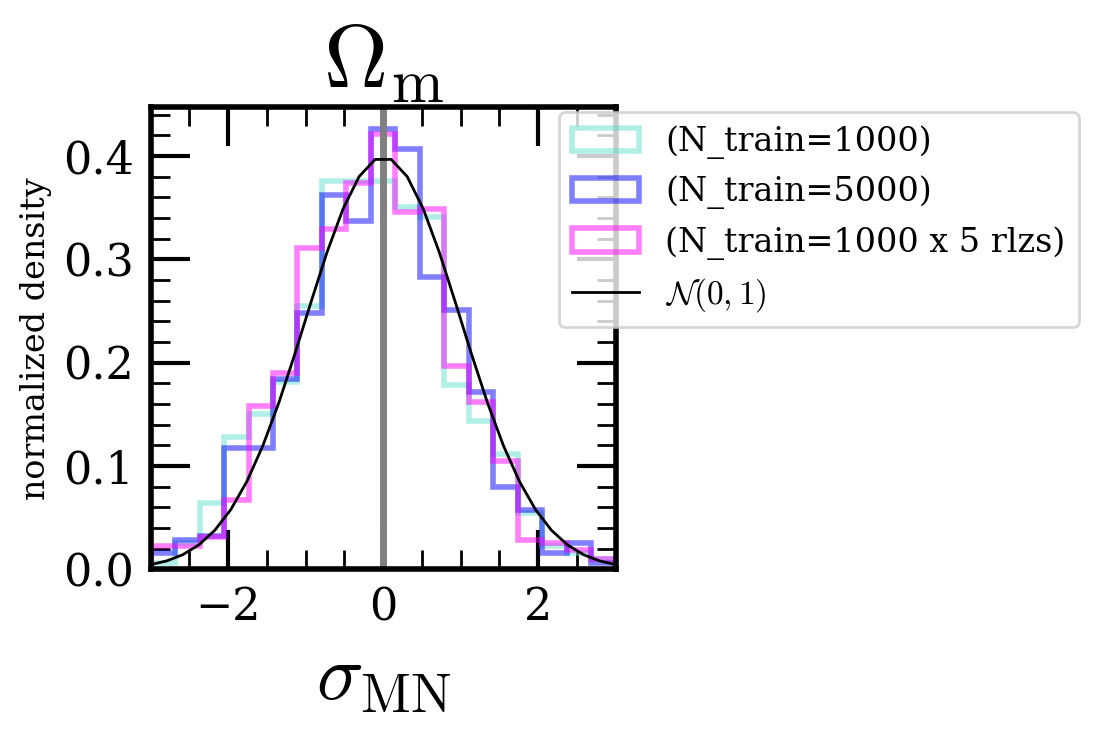

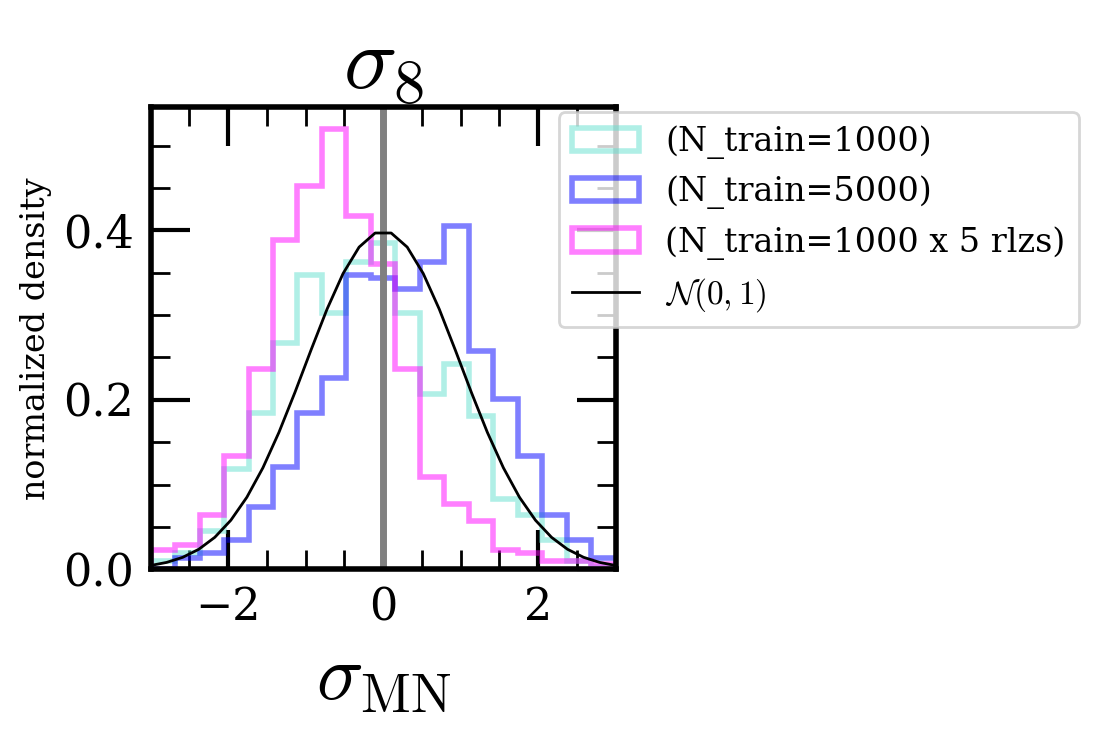

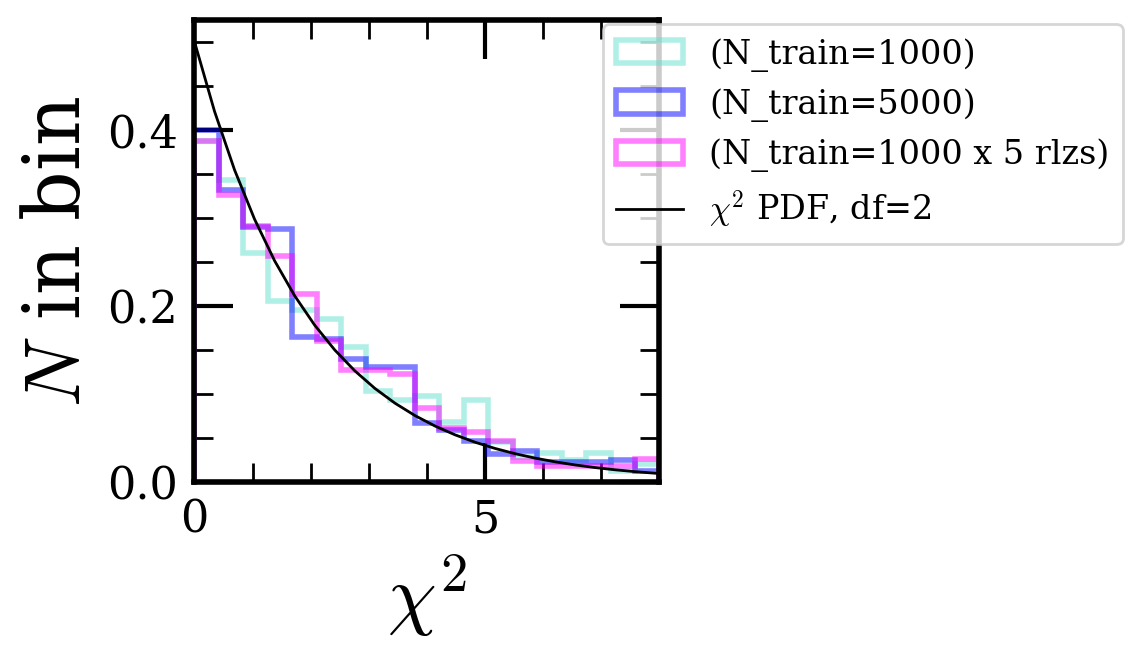

In [41]:
plotter.plot_hists_cov(theta_test_arr, theta_test_pred_arr, covs_test_pred_arr, param_labels,
                       color_arr=colors, label_arr=labels_extra, histtype='step')

In [42]:
tags_inf = ['_emuPk_2param_boxsize500_ntrain1000',
            '_emuPk_2param_boxsize500_ntrain8500',
            '_emuPk_2param_boxsize500_nrlzs9_ntrain1000',
            ]

labels_extra = ['(N_train=1000)',
                '(N_train=8500)', 
                '(N_train=1000 x 9 rlzs)']
#colors = [utils.color_dict_methods[meth] for meth in methods]
colors = ['#63E0CF', '#2E3CA2', 'magenta']
param_labels = [utils.param_label_dict[param_name] for param_name in param_names]

fracdiffs_arr = []
theta_test_arr = []
theta_test_pred_arr = []
covs_test_pred_arr = []
for tag_inf in tags_inf:
    _theta_test_pred, _covs_test_pred  = utils.get_moments_test_mn(tag_inf)
    fracdiffs_mn = (_theta_test_pred - theta_test)/theta_test
    fracdiffs_arr.append(fracdiffs_mn)
    theta_test_arr.append(theta_test)
    theta_test_pred_arr.append(_theta_test_pred)
    covs_test_pred_arr.append(_covs_test_pred)
fracdiffs_arr = np.array(fracdiffs_arr)
theta_test_arr = np.array(theta_test_arr)
theta_test_pred_arr = np.array(theta_test_pred_arr)
covs_test_pred_arr = np.array(covs_test_pred_arr)

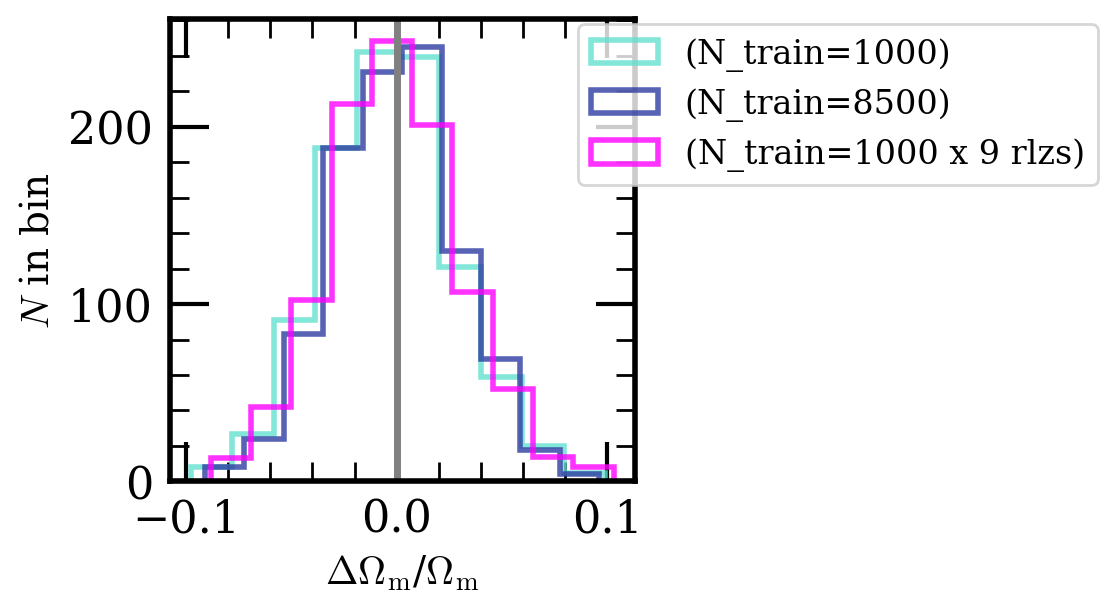

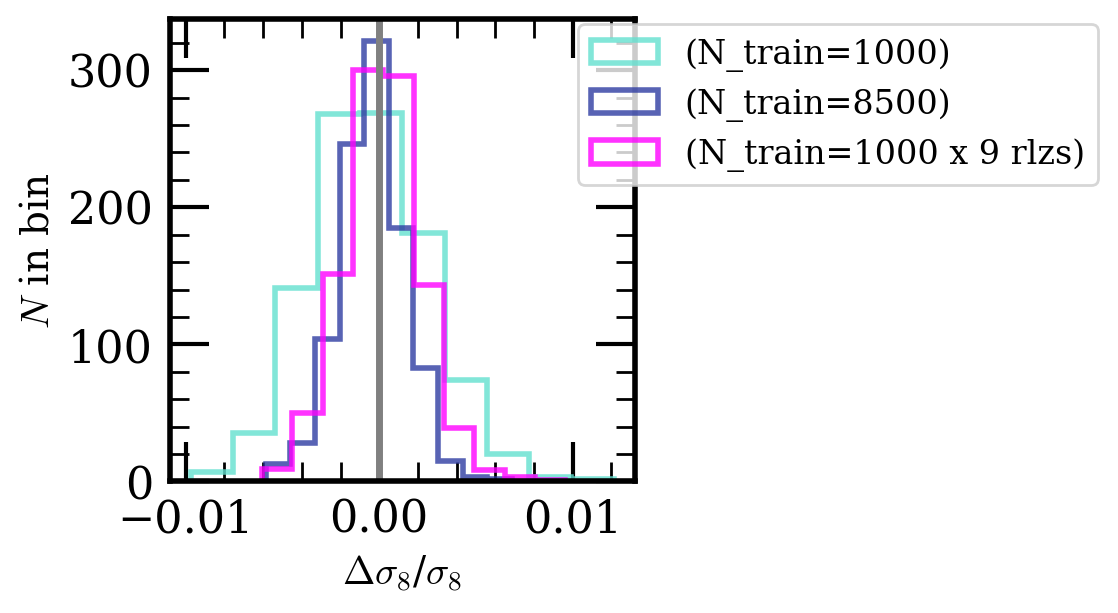

In [43]:
plotter.plot_hists_mean(fracdiffs_arr, param_labels, 
                        color_arr=colors, label_arr=labels_extra,
                        bins=10, alpha=0.8, histtype='step')

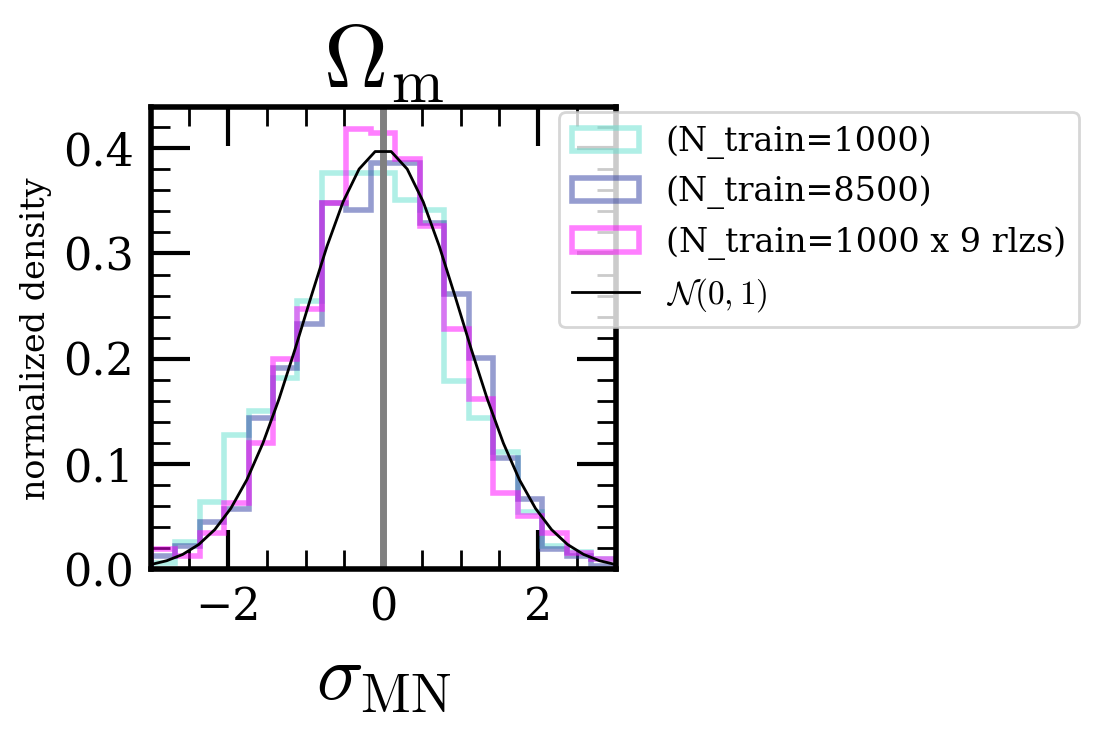

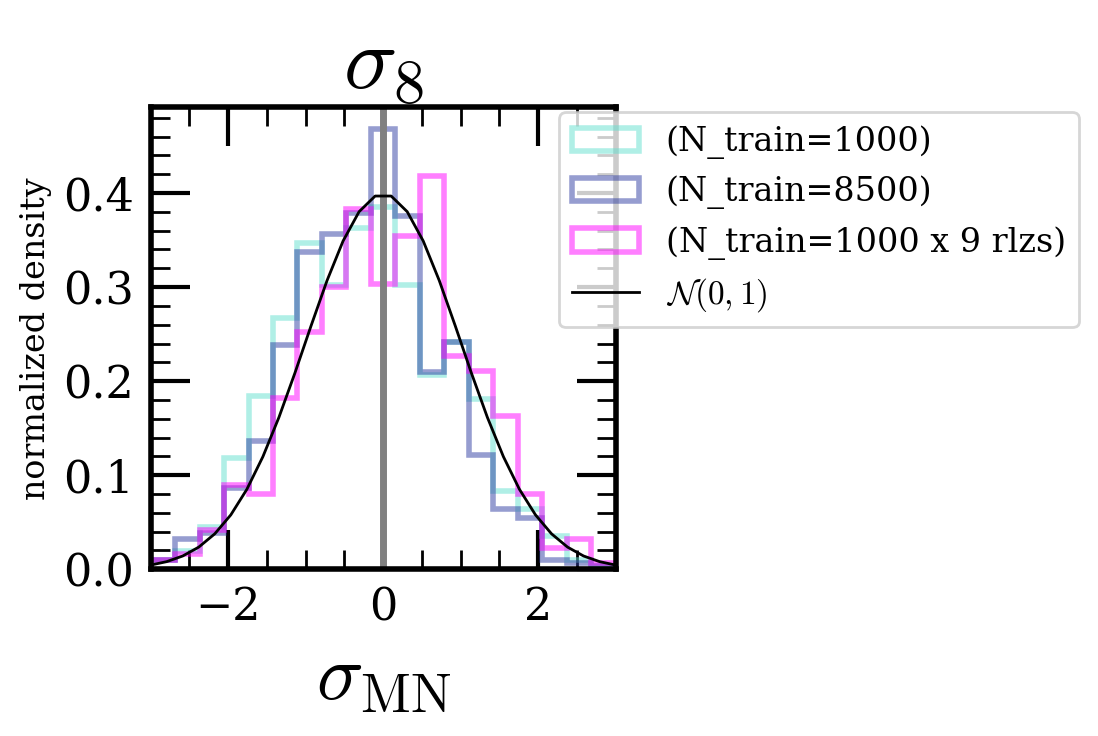

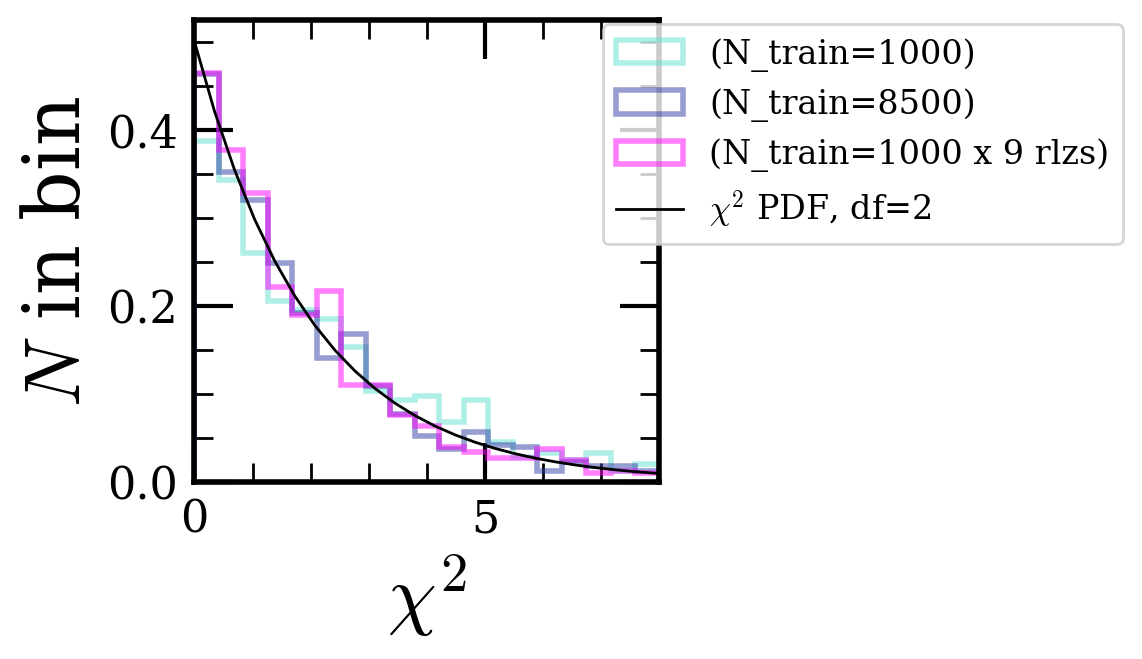

In [44]:
plotter.plot_hists_cov(theta_test_arr, theta_test_pred_arr, covs_test_pred_arr, param_labels,
                       color_arr=colors, label_arr=labels_extra, histtype='step')